In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['MODELSCOPE_CACHE']="/data0/modelscope/qwen2.5"

In [2]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [3]:
import sys
sys.path.insert(0, '/home/hushengchun/python_library/TransformerLens/')

import transformer_lens
from argparse import ArgumentParser
from functools import partial 
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm

from eap.graph import Graph
from eap.attribute import attribute, _plot_attn, tokenize_plus
from eap.evaluate import evaluate_graph, evaluate_baseline

from dataset import EAPDataset
from metrics import get_metric
from transformers import BitsAndBytesConfig
from modelscope import AutoModelForCausalLM, AutoTokenizer

In [4]:
bnbconfig = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type='nf4'
)

In [5]:
# model_name = "qwen/Qwen2.5-32B-Instruct-GPTQ-INT4"
# model_name = "qwen/Qwen2.5-32B-Instruct"
model_name = "Qwen/Qwen2.5-7B-Instruct"
# model_name = "Qwen/Qwen2.5-0.5B"
# model_name = "Qwen/Qwen2.5-0.5B-Instruct"
model_base = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir="/data0/modelscope/qwen2.5",
    local_files_only=True, low_cpu_mem_usage=True,
    quantization_config=bnbconfig
)

2025-04-16 05:40:58,544 - modelscope - WARNING - Using branch: master as version is unstable, use with caution


2025-04-16 05:40:58,759 - modelscope - INFO - Target directory already exists, skipping creation.


In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/config.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/config.json


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

2025-04-16 05:41:05,967 - modelscope - WARNING - Using branch: master as version is unstable, use with caution


2025-04-16 05:41:06,235 - modelscope - INFO - Target directory already exists, skipping creation.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer_config.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer_config.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/vocab.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/merges.txt
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5

In [72]:
# output test
prompt = "Output the execution result (or 'E' for errors) of the following Python program directly. Do not show process.\nq = 2\nd = {2: 3, 9: 4, 3: 8}\nprint(d[q])\n"
messages = [
    {"role": "system", "content": ""},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model_base.device)
generated_ids = model_base.generate(
    **model_inputs,
    max_new_tokens=1,
    temperature=0.0,
    do_sample=False
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
response

'4'

In [7]:
model = HookedTransformer.from_pretrained(model_name,center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    fold_value_biases=False,
    device='cuda',
    hf_model=model_base,
    tokenizer=tokenizer,
    hf_model_4bit=True,
    dtype="float16",
)

In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer_config.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer_config.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/vocab.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/merges.txt
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model Qwen/Qwen2.5-7B-Instruct into HookedTransformer


In [19]:
# output test
prompt = "Output the execution result (or 'E' for errors) of the following Python program directly. Do not show process.\nq = 0\nd = {2: 7, 0: 8, 3: 0}\nprint(d[q])\n"
messages = [
    {"role": "system", "content": ""},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
output = model.generate(
    text,
    max_new_tokens=1,
    temperature=0.0,
    do_sample=False
)
output.removeprefix("system\n\nuser\n" + prompt + '\nassistant\n')

  0%|          | 0/1 [00:00<?, ?it/s]

'E'

In [8]:
task = 'ioi_code'

In [9]:
if model.cfg.load_in_4bit is True:
    model.cfg.use_split_qkv_input = False
else:
    model.cfg.use_split_qkv_input = True
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True

In [10]:
task_metric_name = 'prob_diff'
ds = EAPDataset(task, model_name, filename="data0.csv")
ds.df['clean'] = ds.df['clean'].str.replace('\\\\n', '\n', regex=True) # hsc: 字符串\n替换
ds.df['corrupted'] = ds.df['corrupted'].str.replace('\\\\n', '\n', regex=True) # hsc: 字符串\n替换
ds.df['clean'] = ds.df['clean'].str.replace(" \(or 'E' for errors\)", "")
ds.df['corrupted'] = ds.df['corrupted'].str.replace(" \(or 'E' for errors\)", "")

for i in range(len(ds)):
    prompt_clean = ds.df['clean'][i]
    messages = [
            {"role": "system", "content": "Give a correct answer."},
            {"role": "user", "content": prompt_clean}
        ]
    text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
    ds.df['clean'][i]= text

    prompt_corrupted = ds.df['corrupted'][i]
    messages = [
            {"role": "system", "content": "Give a correct answer."},
            {"role": "user", "content": prompt_corrupted}
        ]
    text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
    ds.df['corrupted'][i]= text
batch_size = 5
dataloader = ds.to_dataloader(batch_size)
task_metric = get_metric(task_metric_name, task, model=model)

/tmp/ipykernel_855504/1117763823.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  ds.df['clean'] = ds.df['clean'].str.replace(" \(or 'E' for errors\)", "")
/tmp/ipykernel_855504/1117763823.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  ds.df['corrupted'] = ds.df['corrupted'].str.replace(" \(or 'E' for errors\)", "")
/tmp/ipykernel_855504/1117763823.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.df['clean'][i]= text
/tmp/ipykernel_855504/1117763823.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.d

In [11]:
# correct_rate test
n_correct = 0
for d in ds:
    prompt = d[0].replace(" (or 'E' for errors)", "")
    messages = [
        {"role": "system", "content": "Give a correct answer."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    text = prompt
#     model_inputs = tokenizer([text], return_tensors="pt").to(model_base.device)
#     generated_ids = model_base.generate(**model_inputs, max_new_tokens=512)
#     generated_ids = [
#         output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
#     ]
#     response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    token_ids, attention_mask, _, _ = tokenize_plus(model, text)
    logits, _ = model.run_with_cache(token_ids, attention_mask = attention_mask)
    probs, idx = logits[0, -1].softmax(-1).topk(5)
    print(list(zip(tokenizer.convert_ids_to_tokens(idx), probs.tolist())))
    response = tokenizer.decode(logits[0, -1].argmax())
    # output = model.generate(text, max_new_tokens=1, temperature=0, do_sample=False)
    # response = output.removeprefix("system\nGive a correct answer.\nuser\n"+ prompt + '\nassistant\n')
    if response != tokenizer.decode([d[2][0]]):
        print(prompt)
        print(response, '!=', tokenizer.decode(d[2][0]))
    else:
        n_correct += 1
print(n_correct / 50)

[('7', 1.0), ('#', 0.0), ('!', 0.0), ('$', 0.0), ('"', 0.0)]
[('0', 1.0), ('The', 2.384185791015625e-07), ('Output', 5.960464477539063e-08), ('7', 5.960464477539063e-08), ('6', 5.960464477539063e-08)]
[('3', 1.0), ('The', 1.1920928955078125e-07), ('Output', 5.960464477539063e-08), ('"', 0.0), ('!', 0.0)]
[('5', 1.0), ('print', 3.5762786865234375e-07), ('4', 1.1920928955078125e-07), ('"', 0.0), ('!', 0.0)]
[('1', 1.0), ('print', 1.7881393432617188e-07), ('2', 1.1920928955078125e-07), ('"', 0.0), ('!', 0.0)]
[('3', 1.0), ('#', 0.0), ('!', 0.0), ('$', 0.0), ('"', 0.0)]
[('9', 1.0), ('#', 0.0), ('!', 0.0), ('$', 0.0), ('"', 0.0)]
[('0', 0.99755859375), ('4', 0.002590179443359375), ('print', 4.708766937255859e-06), ('3', 1.9073486328125e-06), ('The', 1.7285346984863281e-06)]
[('8', 1.0), ('#', 0.0), ('!', 0.0), ('$', 0.0), ('"', 0.0)]
[('3', 1.0), ('4', 5.960464477539062e-07), ('#', 0.0), ('"', 0.0), ('!', 0.0)]
[('5', 1.0), ('9', 5.960464477539063e-08), ('#', 0.0), ('"', 0.0), ('!', 0.0)]


In [11]:
model_name_noslash = model_name.split('/')[-1]

import time
T1 = time.time()
g = Graph.from_model(model)
T2 = time.time()

print('运行时间：%s s' %(T2 - T1))

运行时间：4.640310049057007 s


In [ ]:
T1 = time.time()
attribute(model, g, dataloader, partial(task_metric, mean=True, loss=True), method='EAP-IG', ig_steps=5)
T2 = time.time()

print('运行时间：%s s' %(T2 - T1))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 935747/935747 [00:01<00:00, 743007.41it/s]


运行时间：33.942705154418945 s


In [ ]:
g.edges['m22->logits'].keep = True
g.nodes['m22'].keep = True
g.edges['a21.h2->m22'].keep = True
g.nodes['a21.h2'].keep = True
g.edges['a22.h1->m22'].keep = True
g.nodes['a22.h1'].keep = True
g.edges['a22.h13->m22'].keep = True
g.nodes['a22.h13'].keep = True
g.edges['a19.h22->m22'].keep = True
g.nodes['a19.h22'].keep = True

In [ ]:
g.apply_greedy(800, absolute=False)
# g.prune_dead_nodes()
gs = g.to_graphviz()
gs.draw(f'qwen2_5-7b-ioi_code_mlp.png', prog='dot')

In [17]:
dataloader = tqdm(dataloader)
dataloader = list(dataloader)

100%|██████████| 10/10 [00:00<00:00, 878.04it/s]


layer 0 acc = 0.0
layer 1 acc = 0.0
layer 2 acc = 0.0
layer 3 acc = 0.0
layer 4 acc = 0.0
layer 5 acc = 0.0
layer 6 acc = 0.0
layer 7 acc = 0.0
layer 8 acc = 0.0
layer 9 acc = 0.0
layer 10 acc = 0.0
layer 11 acc = 0.0
layer 12 acc = 0.0
layer 13 acc = 0.0
layer 14 acc = 0.0
layer 15 acc = 0.0
layer 16 acc = 0.0
layer 17 acc = 0.0
layer 18 acc = 0.0
layer 19 acc = 0.0
layer 20 acc = 0.0
layer 21 acc = 0.2
layer 22 acc = 1.0
layer 23 acc = 0.6
layer 24 acc = 1.0
layer 25 acc = 0.8
layer 26 acc = 1.0


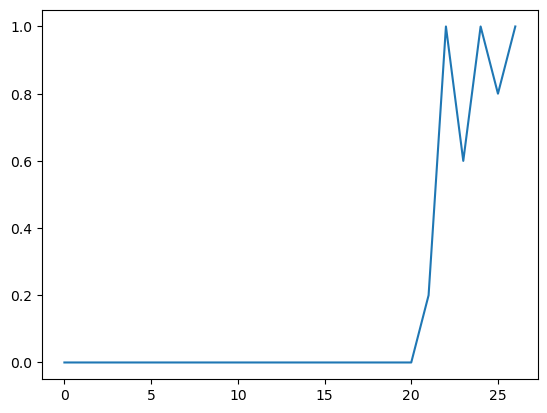

In [98]:
# logits lens
clean, corrupt, label = dataloader[0]
token_ids, attention_mask, input_lengths, n_pos = tokenize_plus(model, clean)
clean_logits, cache = model.run_with_cache(token_ids, attention_mask = attention_mask)
acc = []
for l in range(model.cfg.n_layers - 1):
    n_correct = 0
    for i in range(batch_size):
        hid = cache[f'blocks.{l}.hook_resid_post'][i, -1]
        b = model.blocks[-1]
        hid += b.mlp(b.ln2(hid))
        logits = model.unembed(model.ln_final(hid))
        is_correct = (logits.argmax() == label[i][0]).item()
        n_correct += is_correct
        if False and not is_correct:
            probs, ids = logits.softmax(-1).topk(5)
            print(list(zip(tokenizer.convert_ids_to_tokens(ids), probs.tolist())), tokenizer.decode(label[i][0]))
    acc.append(n_correct / batch_size)
    print(f'layer {l} acc = {n_correct / batch_size}')
plt.plot(range(model.cfg.n_layers - 1), acc)

In [ ]:
layer, head = [(20, 17), 
               (22, 1), # ->correct answer 
               (19, 0), # self
               (22, 13), # ->correct answer 
                (19, 22), # ->correct answer 
                ][4]

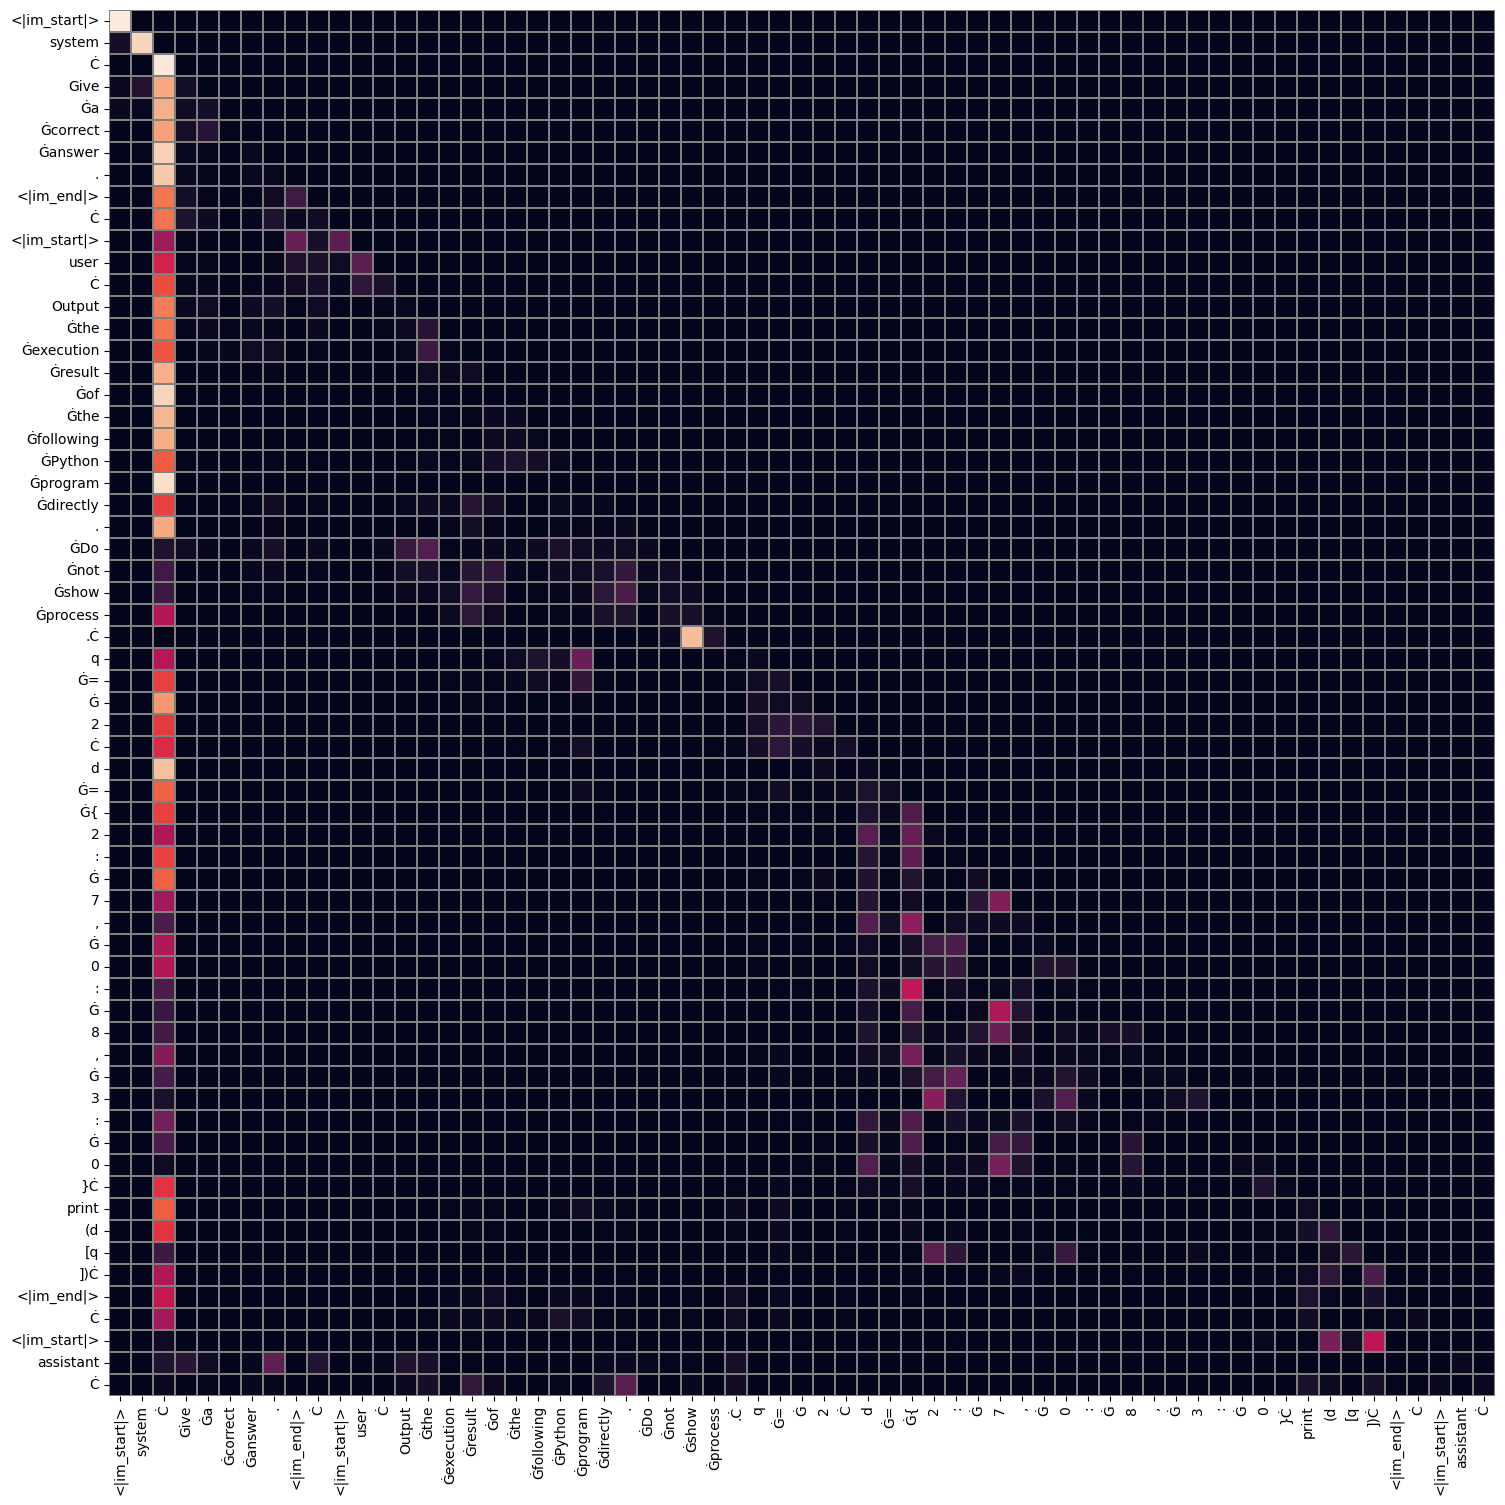

correct answer:  7 predict answer:  7


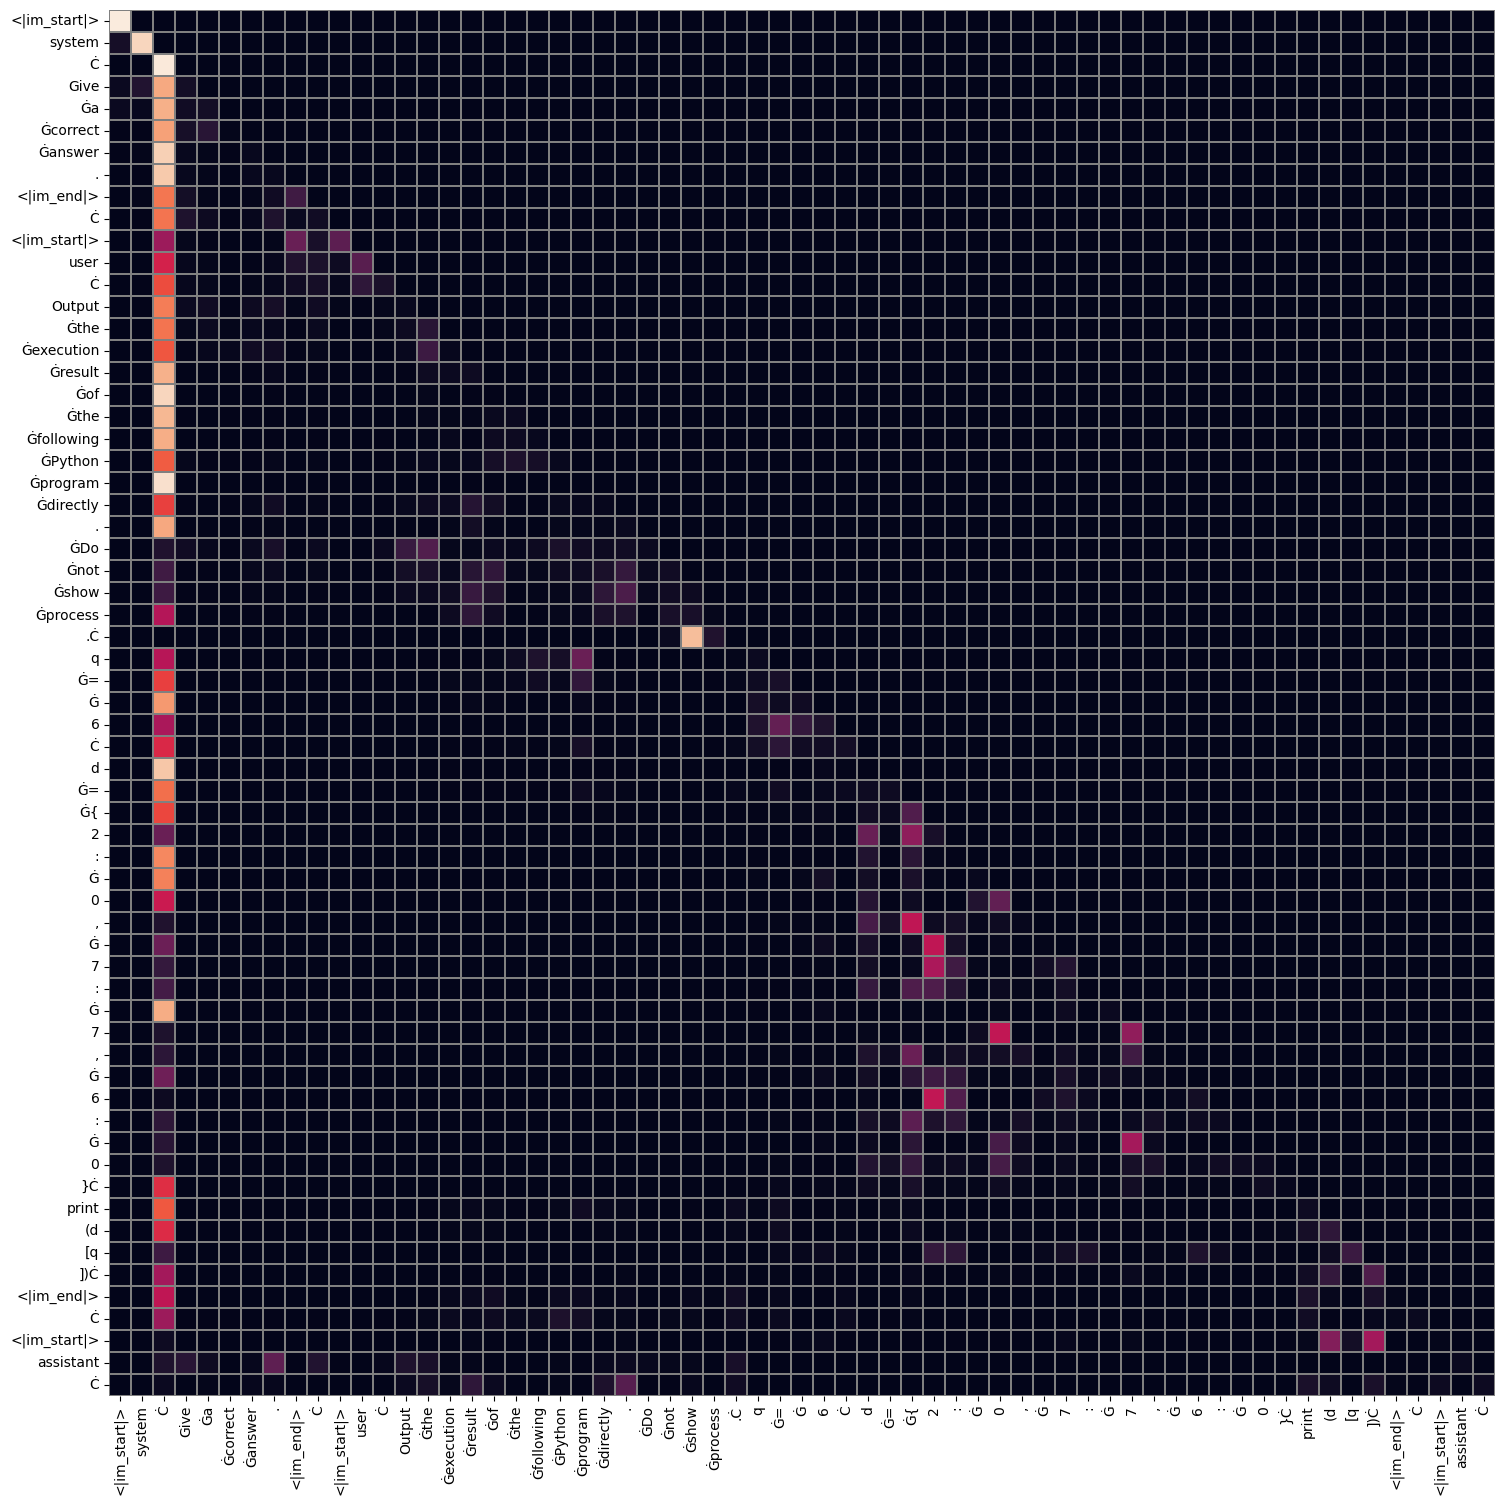

correct answer:  0 predict answer:  0


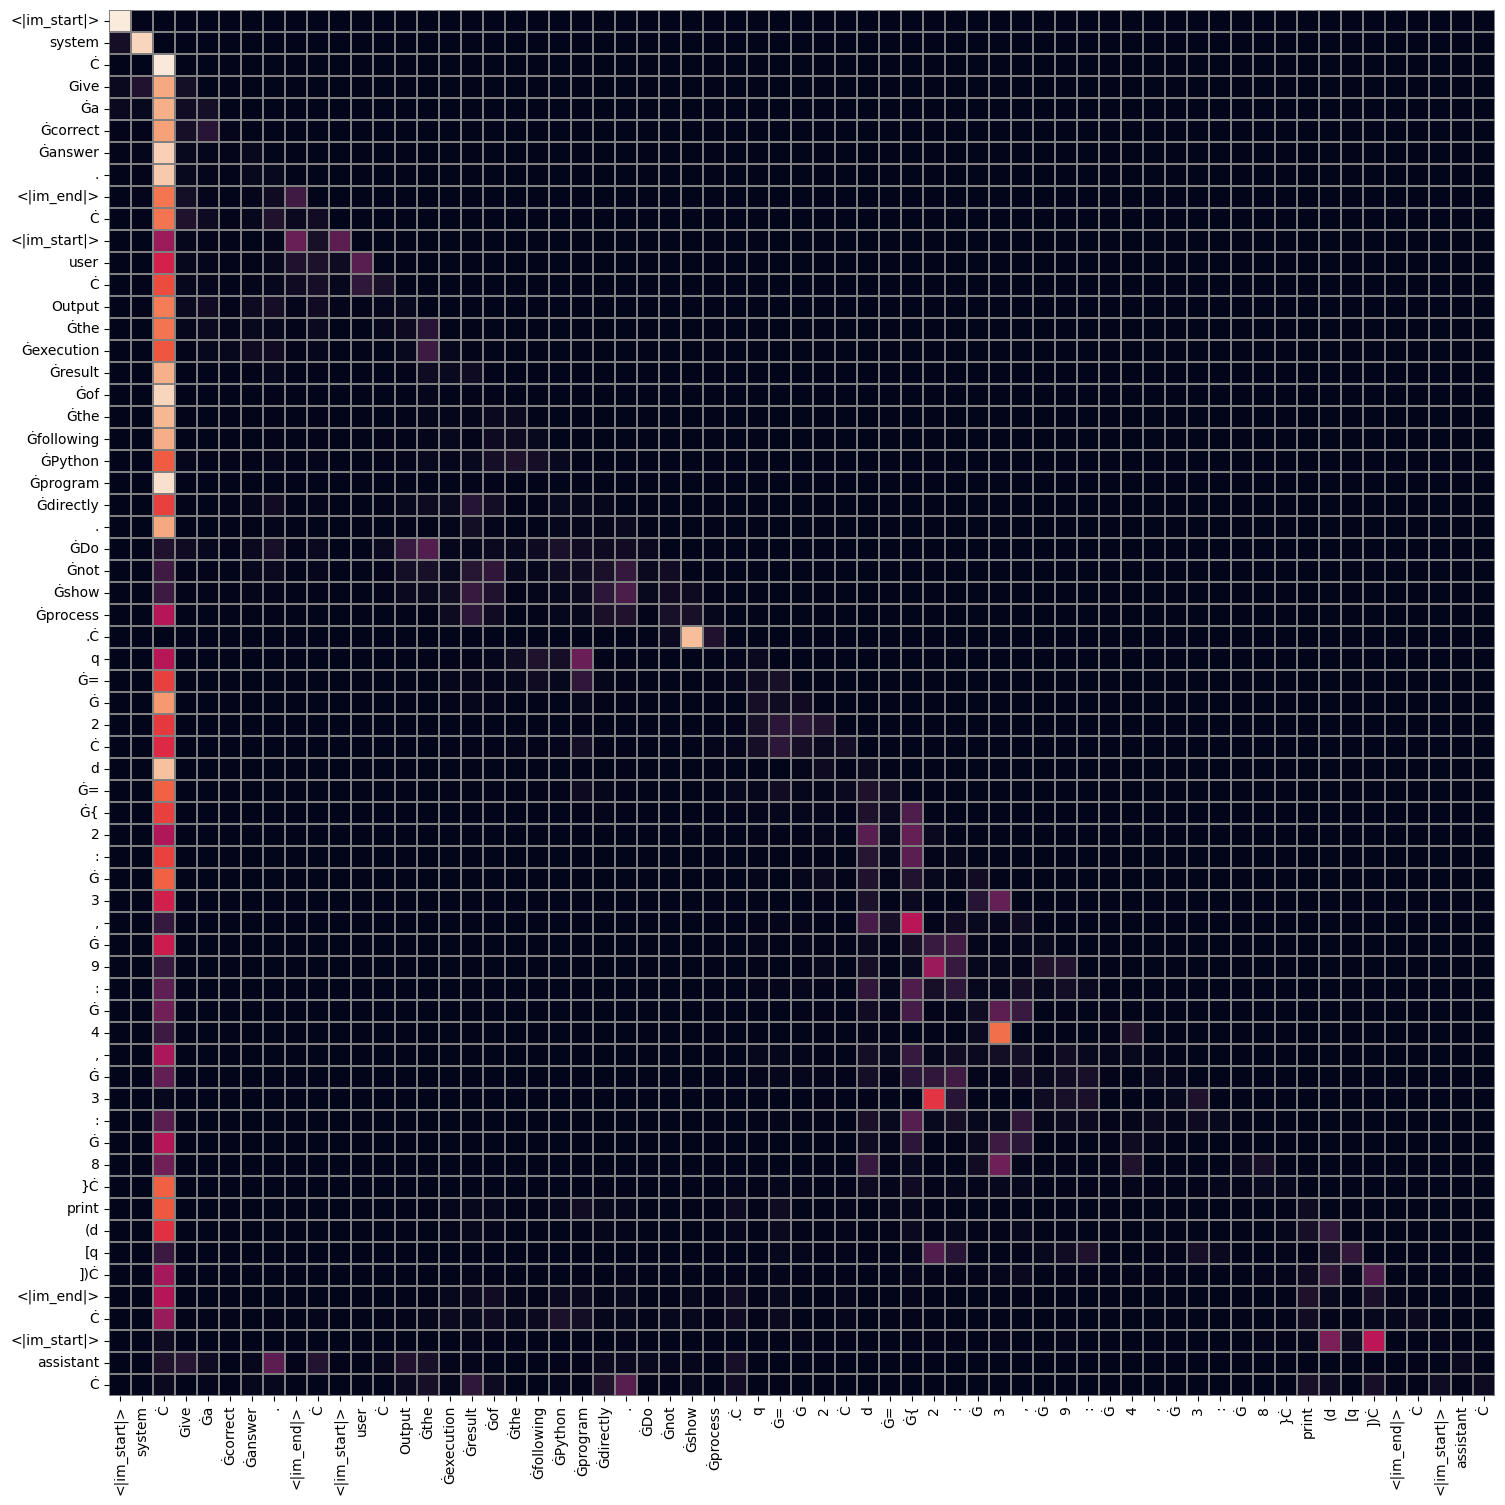

correct answer:  3 predict answer:  3


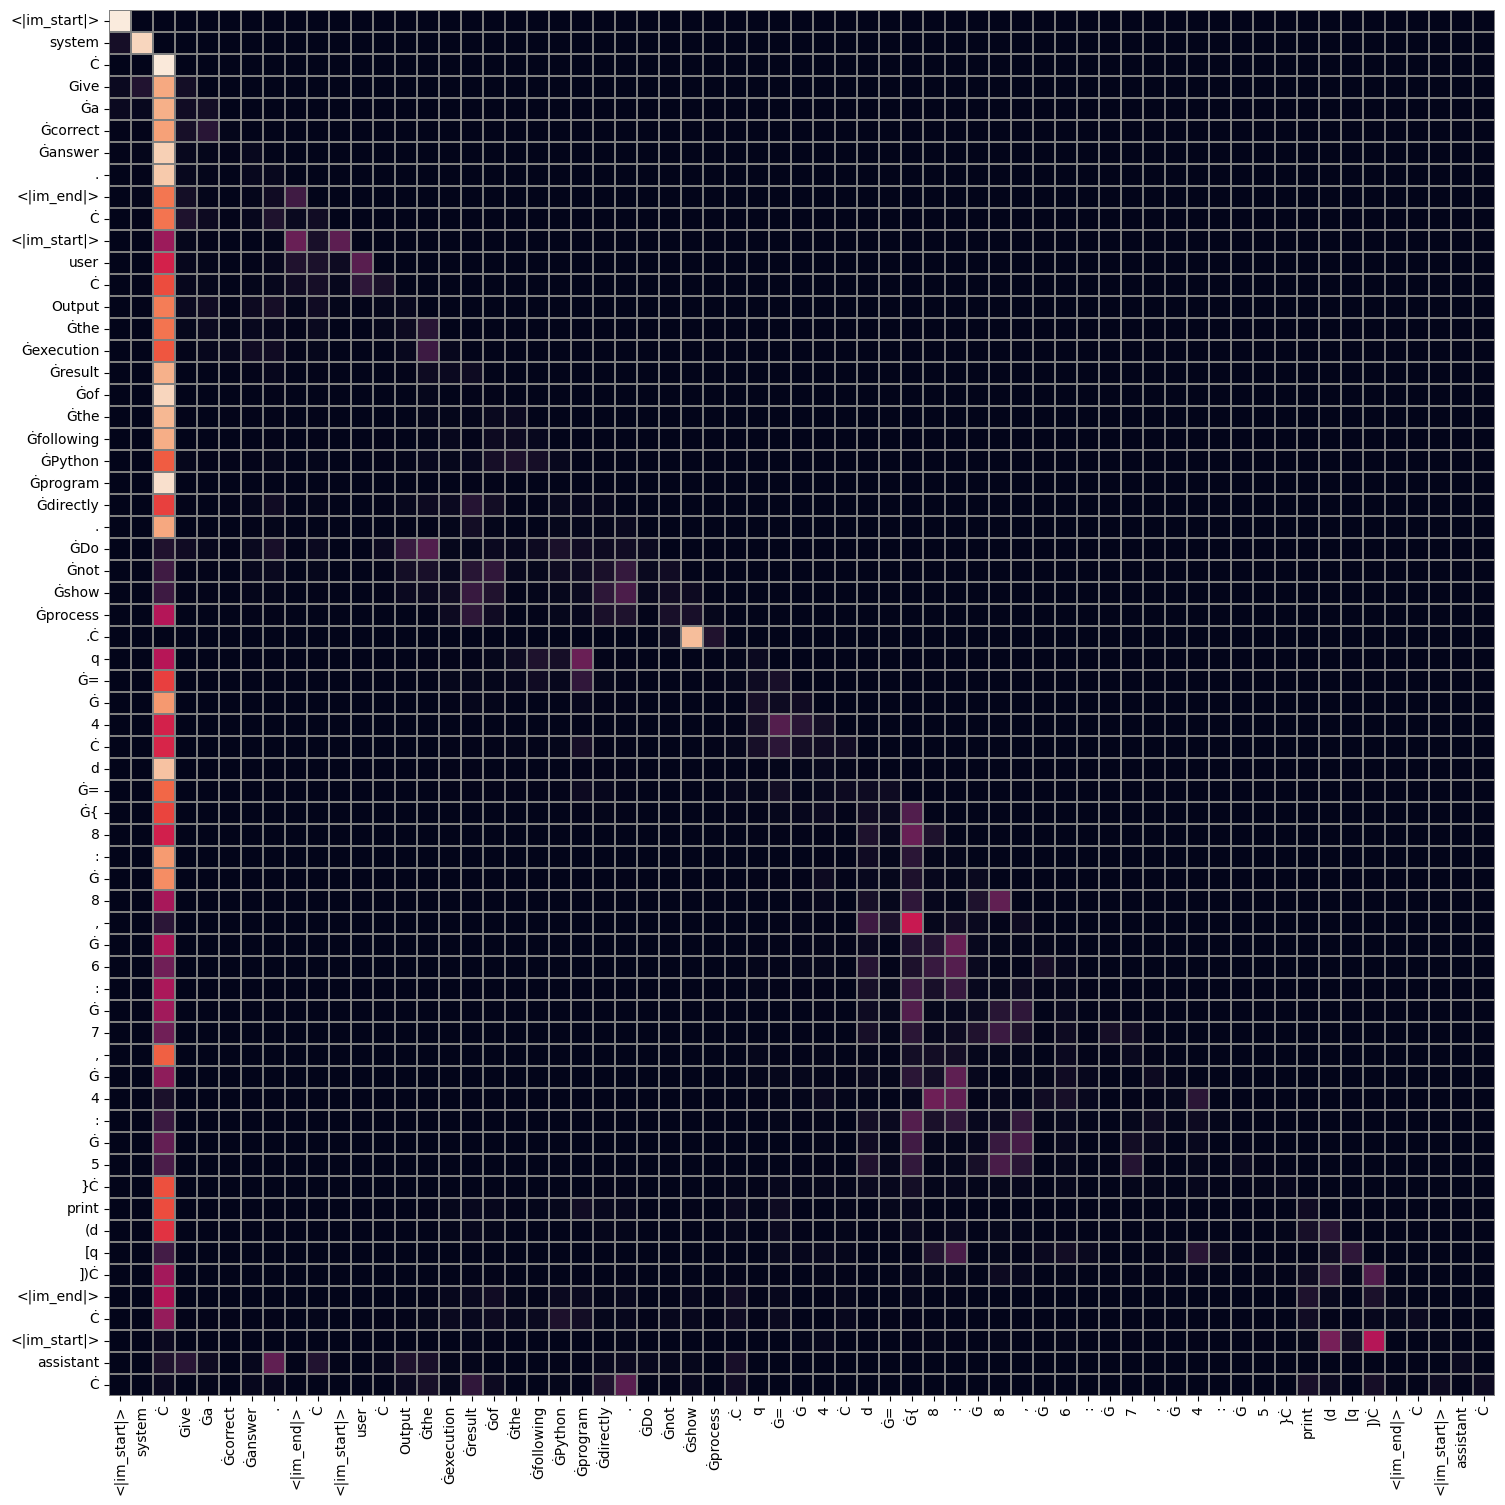

correct answer:  5 predict answer:  5


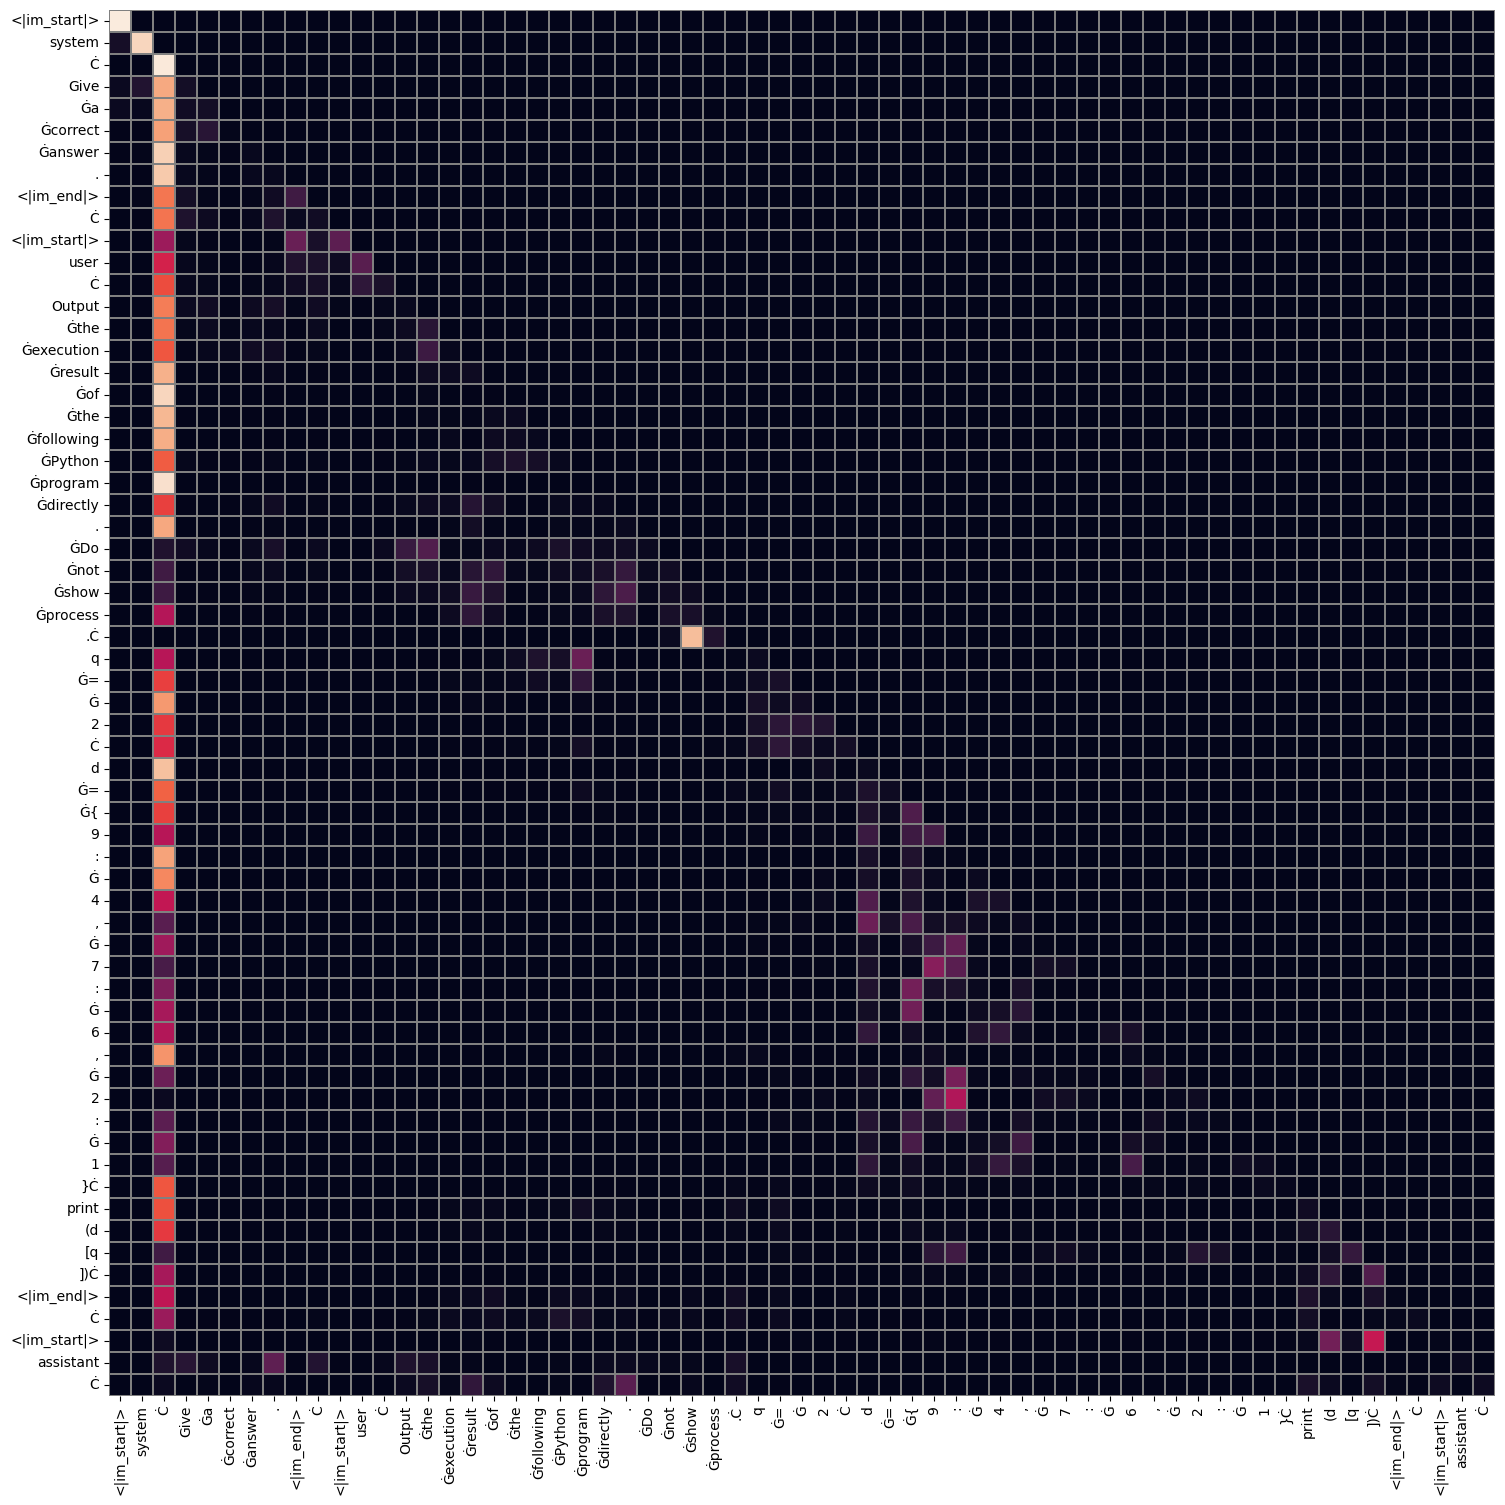

correct answer:  1 predict answer:  1


In [85]:

from eap.attribute import tokenize_plus
for clean, corrupt, label in dataloader[0:1]:
    # tokens_ids = model.to_tokens(clean, prepend_bos=True, padding_side='right')
    token_ids, attention_mask, input_lengths, n_pos = tokenize_plus(model, clean)
    clean_logits, cache = model.run_with_cache(token_ids, attention_mask = attention_mask)
    for i in range(batch_size):
        tokens = tokenizer.convert_ids_to_tokens(token_ids[i])
        attn = cache[f'blocks.{layer}.attn.hook_pattern'][i][head]
        _plot_attn(attn, tokens, figsize=(18, 18))
        print('correct answer: ', tokenizer.decode(label[i][0]), 'predict answer: ', tokenizer.decode(clean_logits[i, -1].argmax()))